# Loading the dataset

/tmp/ipykernel_2252510/3740879258.py:29: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  dQ = cumtrapz(-df['I'], df['t']) / seconds_in_one_hour  # units: Amper-hour
/tmp/ipykernel_2252510/3740879258.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  dE = cumtrapz(-df['P'], df['t']) / seconds_in_one_hour # units: Watt-hour


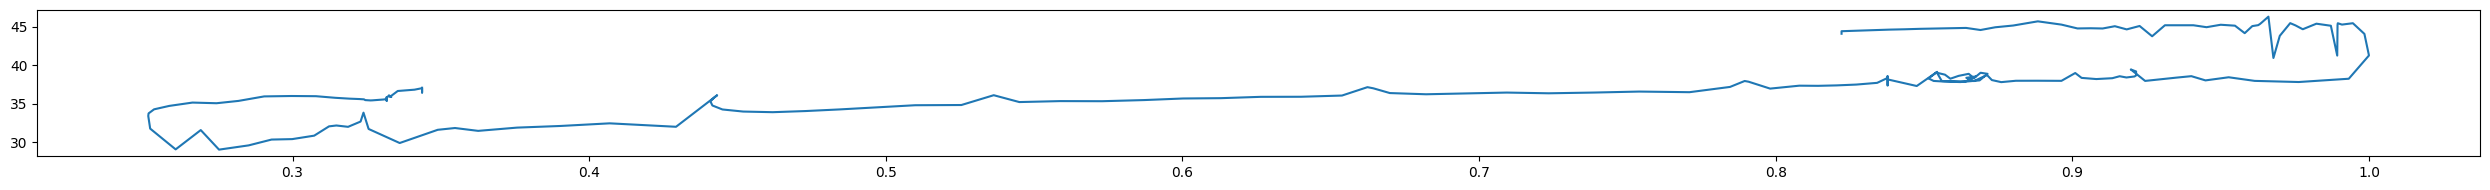

<Figure size 2500x200 with 0 Axes>

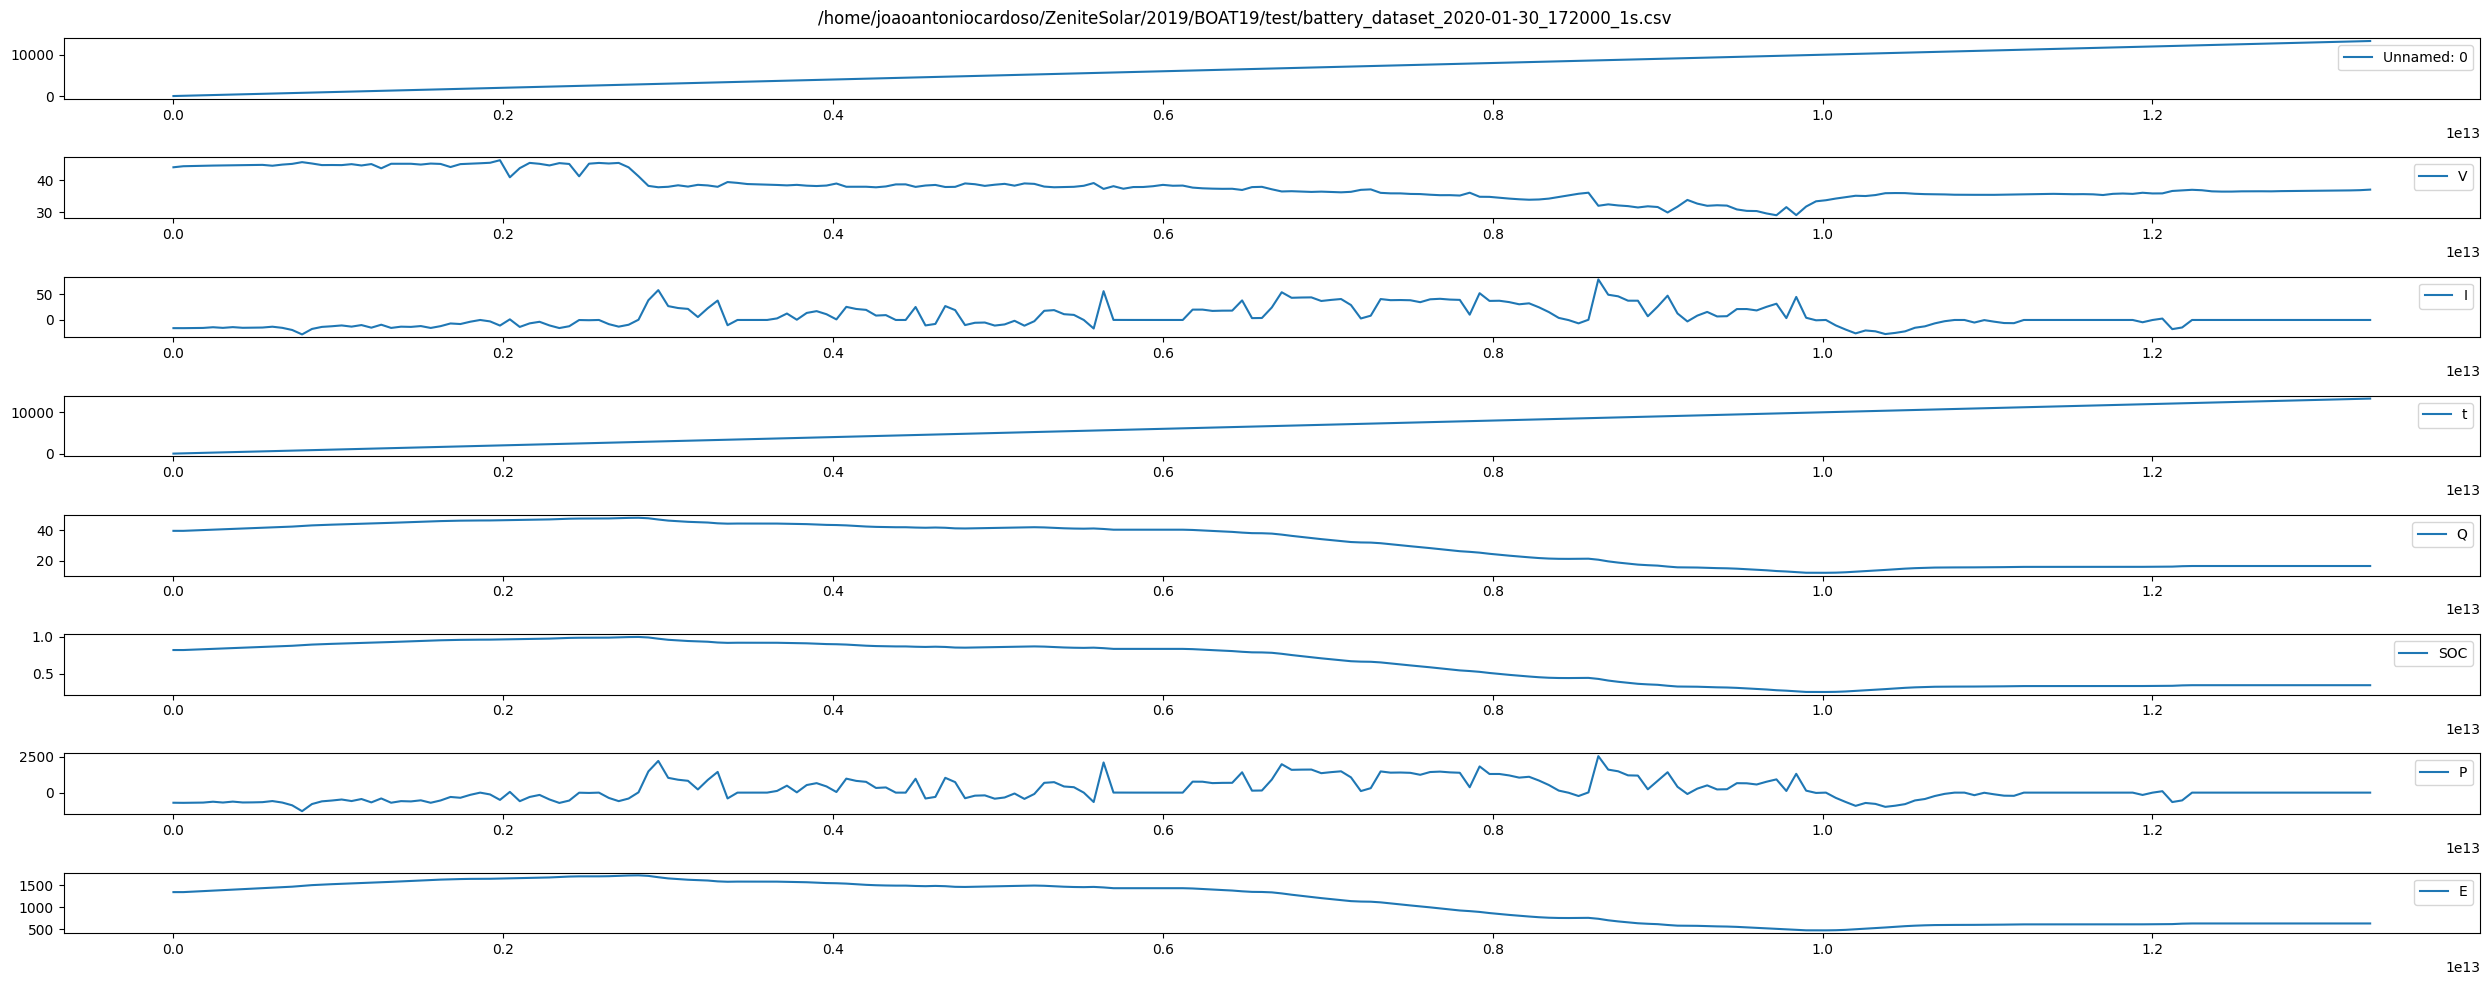

,Unnamed: 0,V,I,t,Q,SOC,P,E
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,6689.434978,37.958480,6.072541,6660.000000,31.140036,0.648751,188.259746,1118.339797
std,3871.011618,4.095043,19.780656,3871.123868,12.924369,0.269258,721.416805,445.223786
min,29.500000,29.015624,-28.269492,0.000000,12.065418,0.251363,-1291.815140,469.170444
25%,3359.500000,35.626697,-7.853833,3330.000000,16.496291,0.343673,-319.940383,626.975449
50%,6689.500000,37.136850,0.000000,6660.000000,37.661176,0.784608,0.000000,1338.586169
75%,10019.500000,38.841962,18.500711,9990.000000,42.636233,0.888255,671.597913,1507.290724
max,13335.000000,46.306309,79.444659,13320.000000,48.000000,1.000000,2541.154385,1728.000000


nans:  0


,Unnamed: 0,V,I,t,Q,SOC,P,E
Time,,,,,,,,
0 days 00:00:00,29.5,44.084269,-15.978034,0.0,39.465639,0.822201,-704.379960,1344.340214
0 days 00:01:00,89.5,44.413586,-16.012333,60.0,39.465639,0.822201,-711.165119,1344.340214
0 days 00:02:00,149.5,44.488303,-15.828339,120.0,39.730978,0.827729,-704.175929,1356.134723
0 days 00:03:00,209.5,44.554942,-15.564214,180.0,39.992583,0.833179,-693.462648,1367.781711
0 days 00:04:00,269.5,44.619557,-14.194605,240.0,40.240573,0.838345,-633.356981,1378.838541
...,...,...,...,...,...,...,...,...
0 days 03:38:00,13109.5,36.716509,0.000000,13080.0,16.496291,0.343673,0.000000,626.975449
0 days 03:39:00,13169.5,36.769049,0.000000,13140.0,16.496291,0.343673,0.000000,626.975449
0 days 03:40:00,13229.5,36.817804,0.000000,13200.0,16.496291,0.343673,0.000000,626.975449


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import cumtrapz
import numpy as np

def compute_df_power(df, inplace=False):
    P = df['I'] * df['V']
    if inplace: df['P'] = P
    return P

def compute_df_energy(df, nominal_E, inplace=False):
    seconds_in_one_hour = 3600
    dE = cumtrapz(-df['P'], df['t']) / seconds_in_one_hour # units: Watt-hour
    dE = np.insert(dE, obj=1, values=dE[0])

    E = nominal_E + dE - dE.max()

    if inplace: df['E'] = E
    return E

def compute_df_soc(df, nominal_Q, inplace=False):
    SOC = df['Q'].to_numpy() / nominal_Q

    if inplace: df['SOC'] = SOC
    return SOC

def compute_df_capacity(df, inplace=False):
    seconds_in_one_hour = 3600.0
    dQ = cumtrapz(-df['I'], df['t']) / seconds_in_one_hour  # units: Amper-hour
    dQ = np.insert(dQ, obj=1, values=dQ[0])

    Q = nominal_Q + dQ - dQ.max()

    if inplace: df['Q'] = Q
    return Q


def load_df(filename, nominal_Q, initial_SOC, resample_rule='1s', rename_columns={}):
    df = pd.read_csv(filename)
    df = df.fillna(0.0)
    df = df.rename(columns=rename_columns)
    df = df[df['V'] > 10]

    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Time'] = df['Time'] - df['Time'][0]

    df = df.set_index('Time', drop=True)

    # Resampling
    df = (df
        .resample(resample_rule)
        .mean()
        .interpolate(method='time', limit_area='inside')
    )

    # After resampling, create the equally-spaced 't' index, used for control simulations
    df['t'] = df.index.to_numpy(dtype='timedelta64[s]').astype(float)  # t is now a float in seconds

    compute_df_capacity(df, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)
    compute_df_power(df, inplace=True)
    compute_df_energy(df, nominal_E, inplace=True)

    return df

filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-01-30_172000_1s.csv'  # Interessante
# filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-02-01_064222_1s.csv'  # Sprint
# filename = '/home/joaoantoniocardoso/ZeniteSolar/2019/BOAT19/test/battery_dataset_2020-02-01_064223_1s.csv'  # After sprint, mostly charging
rename_columns = {'t': 'Time'}

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99
nominal_E = series_cells * parallel_cells * cell_amps_hour * cell_voltage

df = load_df(filename, resample_rule='1min', rename_columns=rename_columns, nominal_Q=nominal_Q, initial_SOC=initial_SOC)

plt.figure(figsize=(25, 2))
plt.plot(df['SOC'], df['V'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(25, 2))

fig, ax = plt.subplots(len(df.columns), figsize=(25,10))
for k, col in enumerate(df.columns):
    ax[k].plot(df.index, df[col], label=col)
    ax[k].legend(loc=1)

plt.suptitle(filename)
plt.tight_layout()
plt.show()

display(df.describe())

# Check for nans in the data
print('nans: ', df.isna().sum().sum())

df

# Model

In [2]:
import control as ct

class Battery:
    """ From: https://books.google.com.br/books?id=suLRCgAAQBAJ&pg=PA29&hl=pt-BR&source=gbs_toc_r&cad=2#v=onepage&q&f=false, pg33
            z_dot(t) = i(t) * (-eta / Q)
        defining:
            x(t) = z(t)
            y(t) = z(t)
            u(t) = i(t)
        then:
            x_dot(t) = u(t) * (-eta / Q)
            y(t) = x(t)
    """
    @classmethod
    def build(cls, params: dict):
        # Get the parameter values
        batt_Q = params["batt_Q"]  # units: Ampere-seconds
        batt_eta = params["batt_eta"]

        # State Transition matrix, shape 'n,n' -> '1x1'
        A = np.array([0])

        # Input matrix, shape 'n,m' -> '1x1'
        B = np.array([-batt_eta / batt_Q])

        # Output matrix, shape 'p,n' -> '1x1'
        C = np.array([1])

        # Remaining matrix, shape 'p,m' -> '1x1'
        D = np.array([0])

        return ct.ss(
            A,
            B,
            C,
            D,
            name="battery",
            states=("SOC",),
            inputs=("I",),
            outputs=("SOC",),
        )

# Optimization

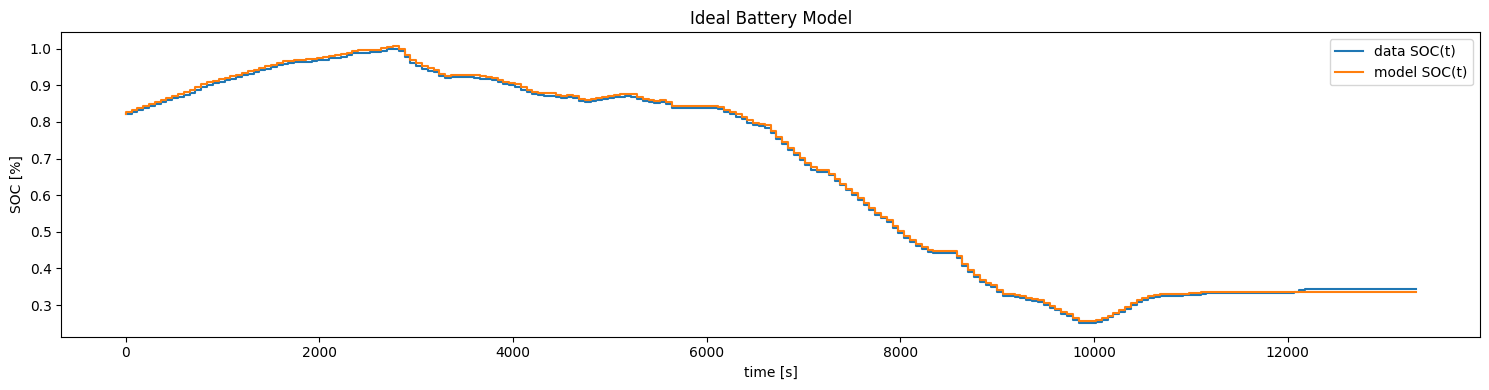

In [3]:
import lmfit

def residuals(params, data):
    # ref: https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html

    # Simulate the system response
    res = ct.input_output_response(
        Battery.build(params.valuesdict()), T=data['t'], U=data['I'], X0=[data['SOC'].iloc[0]], solve_ivp_kwargs={"method": "Radau"}
    ).outputs

    # Calculate residuals
    return res - data['SOC'].to_numpy()

## Initial parameters
initial_eta = 1

## Create lmfit Parameters object and set initial guesses
params = lmfit.Parameters()
params.add('batt_eta', value=initial_eta, min=0.5, max=1.5, vary=True)
params.add('batt_Q', value=nominal_Q * 3600, min=nominal_Q*0.1* 3600, max=nominal_Q*10* 3600, vary=False)  # Ampere-seconds

## Define data to fit
data = {
    't': (df['t'] - df['t'].iloc[0]).to_numpy(),  # simulation time in seconds
    'SOC': df['SOC'],
    'I': df['I'],
}

## Perform the fit
result = lmfit.minimize(residuals, params, args=(data,),method='leastsq')

df_out = ct.input_output_response(
    Battery.build(result.params.valuesdict()), T=data['t'], U=data['I'], X0=[data['SOC'].iloc[0]], solve_ivp_kwargs={"method": "Radau"}
).to_pandas().set_index('time')

## Plot
plt.figure(figsize=(15,4))
plt.title("Ideal Battery Model")
plt.step(df['t'], df["SOC"], label="data SOC(t)")
plt.step(df['t'], df_out["SOC"], label="model SOC(t)")
plt.xlabel("time [s]")
plt.ylabel("SOC [%]")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print the optimized parameters
display(result)

In [4]:
result.params.valuesdict()

{'batt_eta': 1.0000003582914985, 'batt_Q': 172800}